# Dissertation - Study 1: Classical Application of NLP on Beige Books


By Charlie Smith, University of South Alabama

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in bbNoText.csv as bbSimple
bbSimple = pd.read_csv("bbNoText_pop.csv")

# Replace Nan with 0
bbSimple.fillna(0, inplace=True)

# Change Date to datetime format
bbSimple['Date'] = pd.to_datetime(bbSimple['Date'])

In [3]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Split into testing and training datasets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(bbSimple, test_size=0.2, random_state=755)

# Divide up X and Y variables in testing and training sets
X_train = train_set.drop(columns=['econ_index_change_dummy','econ_index', 'econ_index_change','Year','District','file_name','Date','sentiment_trigram','variance_sentiment'])
y_train = train_set['econ_index_change_dummy']
X_test = test_set.drop(columns=['econ_index_change_dummy','econ_index', 'econ_index_change','Year','District','file_name','Date','sentiment_trigram','variance_sentiment'])
y_test = test_set['econ_index_change_dummy']

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=755)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#cv_scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
#cv_predictions = cross_val_predict(model, X, y, cv=k)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred)
# Use predicted probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
# rounded to 2 decimal places
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("Specificity:", round(specificity, 2))
print("AUC:", round(auc, 2))
print("Confusion Matrix:")
print(conf_matrix)



Accuracy: 0.85
Precision: 0.88
Recall: 0.96
Specificity: 0.25
AUC: 0.79
Confusion Matrix:
[[ 36 106]
 [ 35 763]]


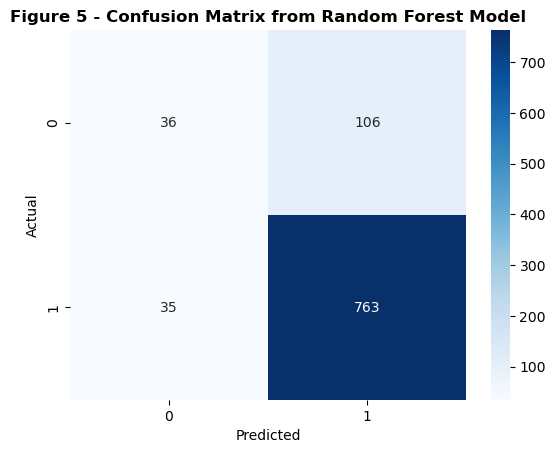

In [4]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 5 - Confusion Matrix from Random Forest Model", fontweight='bold')
plt.savefig("Figure5_confusionMatrix.png")
plt.show()


In [5]:
from sklearn.metrics import classification_report  # Use appropriate metrics for your problem

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Note weakness in predicting 0s, which is expected given the class imbalance


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.25      0.34       142
           1       0.88      0.96      0.92       798

    accuracy                           0.85       940
   macro avg       0.69      0.60      0.63       940
weighted avg       0.82      0.85      0.83       940



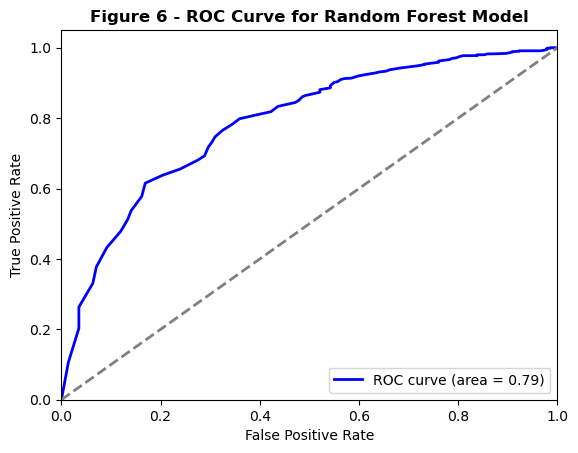

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 6 - ROC Curve for Random Forest Model', fontweight='bold')
plt.legend(loc='lower right')
plt.savefig("Figure_6_ROC_plot.png", bbox_inches='tight')

plt.show()

# Feature Importance

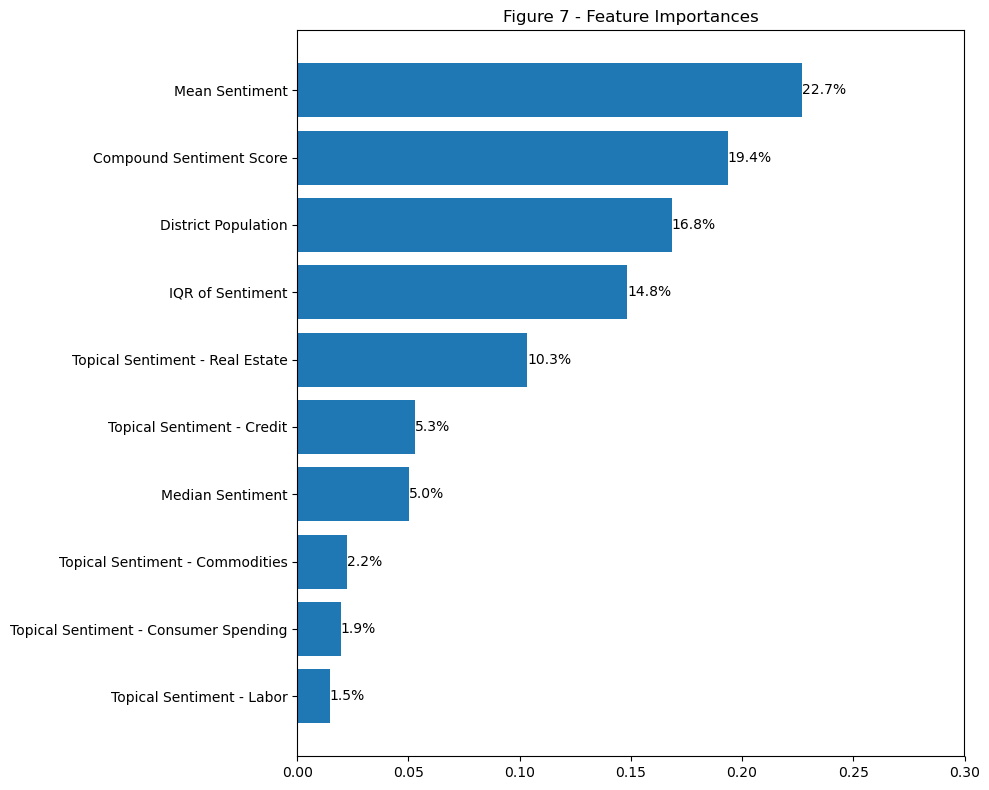

In [8]:
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)

# List of original predictor names
predictors = X_train.columns

# Define a dictionary for more readable names
readable_names = {
    'econ_index_change_dummy': 'Economic Index Change (Dummy)',
    'compound_score': 'Compound Sentiment Score',
    'mean_sentiment': 'Mean Sentiment',
    'median_sentiment': 'Median Sentiment',
    'IQR_sentiment': 'IQR of Sentiment',
    'commodities': 'Topical Sentiment - Commodities',
    'spending': 'Topical Sentiment - Consumer Spending',
    'credit': 'Topical Sentiment - Credit',
    'labor': 'Topical Sentiment - Labor',
    'real_estate': 'Topical Sentiment - Real Estate',
    'population': 'District Population'
}

# Map original predictor names to readable names
readable_predictors = [readable_names.get(col, col) for col in predictors]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Figure 7 - Feature Importances")
bars = plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), np.array(readable_predictors)[indices])
plt.xlim([0, .3])

# Add labels to the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '{:.1f}%'.format(importance*100), 
             va='center', ha='left', color='black')

plt.tight_layout()  # Adjust layout to prevent cutting off
plt.savefig("Figure_7_Feature_importances_balanced.png", bbox_inches='tight')

plt.show()
